In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Load merged data with pit stop info
df_plot = pd.read_csv("../data/merged_f1_data_clean.csv")
df = pd.read_csv("../data/merged_f1_data_with_pit.csv")
df['gridPosition'] = pd.to_numeric(df['gridPosition'], errors='coerce')
df['pitEffect'] = pd.to_numeric(df['pitEffect'], errors='coerce')

# Quick check
df.head()

,resultId,raceId,driverId,constructorId,number,grid,finishPosition,positionText,positionOrder,points,...,forename,surname,driverName,gridPosition,year,Grand Prix,totalPitTime_ms,totalPitTime_s,positionsChange,pitEffect
0,22130,900,3,131,6,3,1.0,1,1,25.0,...,Nico,Rosberg,Nico Rosberg,3.0,2014,Australian Grand Prix,48004.0,48.004,2.0,0.041663
1,22131,900,825,1,20,4,2.0,2,2,18.0,...,Kevin,Magnussen,Kevin Magnussen,4.0,2014,Australian Grand Prix,45423.0,45.423,2.0,0.044031
2,22132,900,18,1,22,10,3.0,3,3,15.0,...,Jenson,Button,Jenson Button,11.0,2014,Australian Grand Prix,44810.0,44.810,8.0,0.178532
3,22133,900,4,6,14,5,4.0,4,4,12.0,...,Fernando,Alonso,Fernando Alonso,5.0,2014,Australian Grand Prix,44865.0,44.865,1.0,0.022289
4,22134,900,822,3,77,15,5.0,5,5,10.0,...,Valtteri,Bottas,Valtteri Bottas,10.0,2014,Australian Grand Prix,58038.0,58.038,5.0,0.086150


In [10]:
# Create target column: 1 if finish in top 3, else 0
df['top3'] = (df['finishPosition'] <= 3).astype(int)

# Select features
# Use gridPosition, pitEffect (from pit stops), constructorId as team
df_model = df[['top3', 'gridPosition', 'pitEffect', 'constructorId']].copy()

# Convert constructorId to dummy variables (one-hot encoding)
df_model = pd.get_dummies(df_model, columns=['constructorId'], drop_first=True)

# Drop rows with NaNs (e.g., missing pitEffect or gridPosition)
df_model = df_model.dropna()


In [11]:
X = df_model.drop('top3', axis=1)
y = df_model['top3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Accuracy: 0.9248366013071896
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       511
           1       0.75      0.81      0.78       101

    accuracy                           0.92       612
   macro avg       0.86      0.88      0.87       612
weighted avg       0.93      0.92      0.93       612



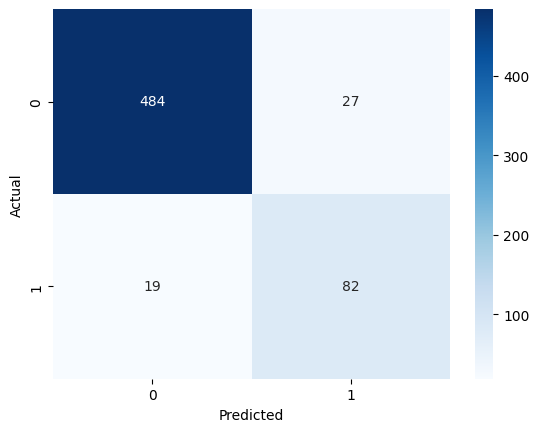

In [12]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


              precision    recall  f1-score   support

  Backmarker       0.82      0.75      0.78        77
    Midfield       0.87      0.92      0.90       353
        Top5       0.91      0.84      0.87       182

    accuracy                           0.88       612
   macro avg       0.87      0.84      0.85       612
weighted avg       0.88      0.88      0.88       612



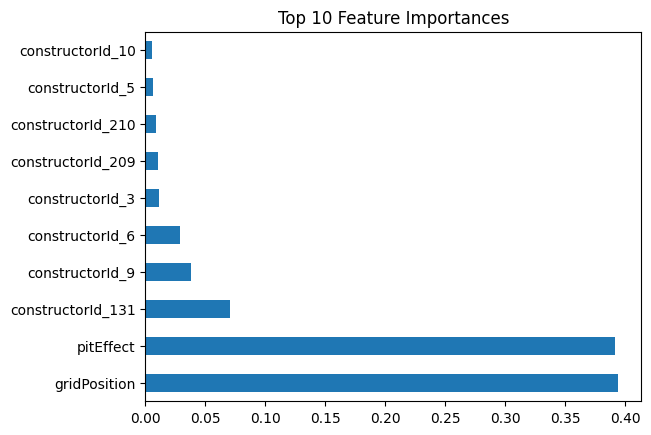

In [13]:
# Create position group
def position_group(pos):
    if pos <= 5:
        return 'Top5'
    elif pos <= 15:
        return 'Midfield'
    else:
        return 'Backmarker'

df['positionGroup'] = df['finishPosition'].apply(position_group)

# Features: grid, pitEffect, constructorId
df_rf = df[['positionGroup', 'gridPosition', 'pitEffect', 'constructorId']].copy()
df_rf = pd.get_dummies(df_rf, columns=['constructorId'], drop_first=True)
df_rf = df_rf.dropna()

X_rf = df_rf.drop('positionGroup', axis=1)
y_rf = df_rf['positionGroup']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_rf, y_train_rf)

y_pred_rf = rf.predict(X_test_rf)

# Evaluation
print(classification_report(y_test_rf, y_pred_rf))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_rf.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()


In [7]:
# Make a copy of the test set with actual and predicted
df_rf_results = X_test_rf.copy()

# Add actual group and predicted group
df_rf_results['actualGroup'] = y_test_rf
df_rf_results['predictedGroup'] = y_pred_rf

# Add driver names and race info from your original dataframe
# Make sure the index aligns (use the same test split indices)
df_rf_results['driverName'] = df_plot.loc[y_test_rf.index, 'driverName']
df_rf_results['raceId'] = df_plot.loc[y_test_rf.index, 'raceId']
df_rf_results['Grand Prix'] = df_plot.loc[y_test_rf.index, 'Grand Prix']
df_rf_results['year'] = df_plot.loc[y_test_rf.index, 'year']
df_rf_results['finishPosition'] = df_plot.loc[y_test_rf.index, 'finishPosition']

# Now you can inspect
df_rf_results[['driverName', 'Grand Prix', 'year', 'finishPosition', 'actualGroup', 'predictedGroup']].head(20)


,driverName,Grand Prix,year,finishPosition,actualGroup,predictedGroup
2189,Charles Leclerc,Canadian Grand Prix,2019,3,Top5,Top5
266,Felipe Massa,Italian Grand Prix,2014,3,Top5,Top5
1691,Max Verstappen,Chinese Grand Prix,2018,5,Top5,Top5
1808,Kimi Räikkönen,Austrian Grand Prix,2018,2,Top5,Top5
1962,Stoffel Vandoorne,Russian Grand Prix,2018,16,Backmarker,Midfield
135,Jenson Button,Canadian Grand Prix,2014,4,Top5,Midfield
3448,Sergio Pérez,British Grand Prix,2022,2,Top5,Top5
2244,George Russell,Austrian Grand Prix,2019,18,Backmarker,Backmarker
610,Felipe Massa,Belgian Grand Prix,2015,6,Midfield,Midfield
1790,Daniel Ricciardo,French Grand Prix,2018,4,Top5,Top5
